# [A model to predict the delta run expectancy of a pitch that is swung at]

In [1]:
import pandas as pd
import time as time
import numpy as np

import pybaseball
from pybaseball import statcast
from pybaseball import chadwick_register

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

import hyperopt.hp as hp
from hyperopt import fmin, tpe, Trials, STATUS_OK

import joblib

In [2]:
path = '/Users/aidanbeilke/Desktop/Baseball Projects'

data = pd.read_csv(f"{path}/attack_df.csv")

In [3]:
cols = ['balls', 'strikes', 'release_speed','release_spin_rate' ,'pitch_type', 'pfx_x', 'pfx_z', 'delta_run_exp', 'plate_x', 'plate_z', 'attack_zone', 'p_throws']

continuous_cols = ['plate_x', 'plate_z', 'release_speed', 'pfx_x', 'pfx_z', 'release_spin_rate']

cat_cols = ['balls', 'strikes', 'pitch_type', 'attack_zone', 'p_throws']

In [4]:
# Swings Only

data_ = data[data['description'].isin(['hit_into_play', 'swinging_strike', 'foul'])]

In [5]:
model_df = data_[cols]

model_df.shape

(326468, 12)

In [6]:
model_df[continuous_cols] = StandardScaler().fit_transform(model_df[continuous_cols])


/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_82046/4067100459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[continuous_cols] = StandardScaler().fit_transform(model_df[continuous_cols])


In [7]:
model_df.shape

(326468, 12)

### Check NA Values

In [8]:
model_df.columns[model_df.isna().any()].tolist()

['release_speed',
 'release_spin_rate',
 'pitch_type',
 'pfx_x',
 'pfx_z',
 'delta_run_exp',
 'plate_x',
 'plate_z']

In [9]:
def calculate_null_percentage(df):

    null_pct = df.isnull().mean()
    return null_pct

null_pct = calculate_null_percentage(model_df)
null_pct

balls                0.000000
strikes              0.000000
release_speed        0.000383
release_spin_rate    0.006062
pitch_type           0.000386
pfx_x                0.000383
pfx_z                0.000383
delta_run_exp        0.000006
plate_x              0.000383
plate_z              0.000383
attack_zone          0.000000
p_throws             0.000000
dtype: float64

In [10]:
model_df = model_df.dropna()

In [11]:
cats = ['pitch_type', 'attack_zone', 'p_throws']

for i in cats:
    model_df[i] = model_df[i].astype('category').cat.codes

model_df

,balls,strikes,release_speed,release_spin_rate,pitch_type,pfx_x,pfx_z,delta_run_exp,plate_x,plate_z,attack_zone,p_throws
0,1,2,1.147286,0.686780,6,-0.470652,1.485820,-0.074,-2.039231,1.251329,3,1
1,1,2,1.213687,0.414852,6,-0.639709,1.341145,0.000,0.051406,0.632344,1,1
3,0,1,-0.346738,1.555193,13,0.915622,-0.785574,-0.023,0.253726,-2.606536,0,1
4,0,0,1.114085,1.312505,6,-0.729874,1.456885,-0.017,-0.504973,1.654390,2,1
5,0,0,1.097485,0.926544,6,-0.921472,1.442417,-0.169,0.624645,-0.476073,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
713540,0,2,1.529092,0.052283,12,-1.597703,0.111410,-0.065,-1.010772,-0.001037,2,1
713543,0,2,1.280088,0.619529,6,-1.011637,0.892653,-0.107,-1.634592,2.287771,0,1
713544,0,1,0.118069,0.020119,13,0.329555,0.024605,-0.036,0.456045,1.121774,1,1
713545,0,0,1.346489,-0.243036,12,-1.699138,-0.177940,-0.026,0.051406,-0.778368,2,1


### Model Selection

In [12]:
X = model_df[continuous_cols + cat_cols]
y = model_df['delta_run_exp']

In [13]:
models = [
    LinearRegression(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    Ridge(alpha=1)
]

names = [
    'Linear Regression',
    'KNN',
    'Decision Tree',
    'Random Forest',
    'Gradient Boosting',
    'XGBoost',
    'Ridge'
]

In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [18]:
results = []

for reg, name in zip(models, names):
    start = time.time()
    cv_results = cross_validate(reg, X, y, cv=5, scoring={
        'MSE': make_scorer(mean_squared_error, greater_is_better=False),
        'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
        'R2': 'r2',
        'RMSE' : rmse_scorer
    })
    stop_time = time.time()

    print('Time to cross-validate %s = %0.3f min.' % (name, (stop_time - start) / 60))

    results.append({
        'Regressor': name,
        'MSE': -cv_results['test_MSE'].mean(),  
        'MAE': -cv_results['test_MAE'].mean(),
        'R^2 Score': cv_results['test_R2'].mean(),
        'RMSE' : -cv_results['test_RMSE'].mean()
    })
    
    results_df = pd.DataFrame(results)

Time to cross-validate Linear Regression = 0.038 min.
Time to cross-validate KNN = 1.332 min.
Time to cross-validate Decision Tree = 0.442 min.
Time to cross-validate Random Forest = 25.089 min.
Time to cross-validate Gradient Boosting = 4.696 min.
Time to cross-validate XGBoost = 0.142 min.
Time to cross-validate Ridge = 0.013 min.


In [20]:
results_df.head(6)

,Regressor,MSE,MAE,R^2 Score,RMSE
0,Linear Regression,0.119049,0.186737,0.002947,0.345031
1,KNN,0.141513,0.230814,-0.185231,0.376180
2,Decision Tree,0.267734,0.306991,-1.242532,0.517423
3,Random Forest,0.123001,0.207088,-0.030161,0.350711
4,Gradient Boosting,0.117764,0.187840,0.013705,0.343164
5,XGBoost,0.119016,0.192419,0.003218,0.344983


### Gradient Boosting Out-of-Box Params Results

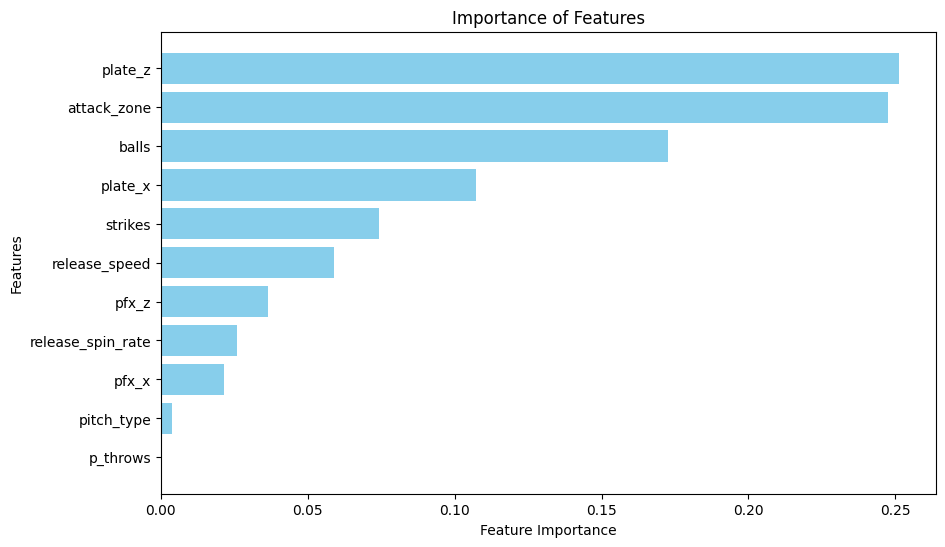

RMSE of the Gradient Boosting on test set: 0.341
R^2 Score of the Gradient Boosting on test set: 0.013
MAE of the Gradient Boosting on test set: 0.187


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
orig_model = GradientBoostingRegressor()
orig_model.fit(X_train, y_train)

# Feature Importance
feat_imp = orig_model.feature_importances_
sorted_indices = np.argsort(feat_imp)
predictors = X.columns.tolist()  # ensure X is a DataFrame for this line to work

# Sort feature importances and corresponding feature names
feat_imp_sorted = feat_imp[sorted_indices]
predictors_sorted = [predictors[i] for i in sorted_indices]

# Create a horizontal bar plot for sorted feature importances
plt.figure(figsize=(10, 6))
plt.barh(predictors_sorted, feat_imp_sorted, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Importance of Features')
plt.show()

# Model Evaluation for Regression
y_pred = orig_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print('RMSE of the Gradient Boosting on test set: {:.3f}'.format(rmse))
print('R^2 Score of the Gradient Boosting on test set: {:.3f}'.format(r2))
print('MAE of the Gradient Boosting on test set: {:.3f}'.format(mae))

### Gradient Boosting Tuning

In [45]:
space = {
    'n_estimators': hp.choice('n_estimators', np.arange(100, 1001, 50, dtype=int)),
    'max_depth': hp.choice('max_depth', np.arange(3, 16, 1, dtype=int)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'min_samples_split': hp.choice('min_samples_split', np.arange(2, 21, 1, dtype=int)),
    'min_samples_leaf': hp.choice('min_samples_leaf', np.arange(1, 15, 1, dtype=int)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'max_features': hp.choice('max_features', ['log2', 'sqrt', None] + list(np.arange(0.5, 1.01, 0.1)))
}

In [46]:
def objective(space):
    clf = GradientBoostingRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        learning_rate=space['learning_rate'],
        min_samples_split= space['min_samples_split'],
        min_samples_leaf = space['min_samples_leaf'],
        subsample=space['subsample'],
        max_features= space['max_features'],
        random_state=42
    )
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    return {'loss': rmse, 'status': STATUS_OK}

In [48]:
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)

print("Best: ", best)

100%|██████████| 20/20 [1:26:24<00:00, 259.21s/trial, best loss: 0.3412547535466985] 
Best:  {'learning_rate': 0.05772587124383198, 'max_depth': 0, 'max_features': 5, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 9, 'subsample': 0.5205320658276944}


In [54]:
## Params from best

params = {
    'learning_rate': 0.05772587124383198,
    'max_depth': None,
    'max_features': int(5.0),
    'min_samples_leaf': int(7.0),  
    'min_samples_split': int(6.0),  
    'n_estimators' : int(9.0),
    'subsample' : 0.5205320658276944
}

In [55]:
model = GradientBoostingRegressor(
    learning_rate = params['learning_rate'],
    max_depth=params['max_depth'],
    max_features = params['max_features'],
    min_samples_leaf=params['min_samples_leaf'],
    min_samples_split= params['min_samples_split'],
    subsample = params['subsample'],
    n_estimators=9
)

# Fit the model with your training data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [56]:
preds = pd.DataFrame(y_pred)

preds.describe()

,0
count,64898.000000
mean,-0.017086
std,0.038651
min,-0.150644
25%,-0.042909
50%,-0.021887
75%,0.004950
max,0.230930


In [57]:
rmse

0.3436307871493882

In [59]:
y.std()

0.34554677367004316

### Save Model

In [61]:
model_path = '/Users/aidanbeilke/Desktop/Baseball Projects/Swing_Decision/sd_swing_model.pkl'

joblib.dump(model, model_path)

['/Users/aidanbeilke/Desktop/Baseball Projects/Swing_Decision/sd_swing_model.pkl']

### Test on 2024 Data

In [15]:
year = 2024

df = statcast(start_dt= f"{year}-03-30",
                end_dt = f"{year}-05-30")

This is a large query, it may take a moment to complete


/Users/aidanbeilke/Desktop/Baseball Projects/.venv/lib/python3.11/site-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)
  0%|          | 0/62 [00:00<?, ?it/s]/Users/aidanbeilke/Desktop/Baseball Projects/.venv/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing

In [16]:
df['attack_zone'] = ""

df.loc[(df['plate_x'].between(-0.558, 0.558)) & (df['plate_z'].between(1.833, 3.166)), 'attack_zone'] = 'heart'
df.loc[(df['plate_x'].between(-1.100, 1.100)) & (df['plate_z'].between(1.166, 3.833)) & (~df['attack_zone'].isin(['heart'])), 'attack_zone'] = 'shadow'
df.loc[(df['plate_x'].between(-1.166, 1.666)) & (df['plate_z'].between(0.5, 4.5)) & (~df['attack_zone'].isin(['heart', 'shadow'])), 'attack_zone'] = 'chase'

df.loc[df['attack_zone'] == "", 'attack_zone'] = 'waste'

In [17]:
df[continuous_cols] = StandardScaler().fit_transform(df[continuous_cols])


In [18]:
calculate_null_percentage(df[cols])

balls                0.000000
strikes              0.000000
release_speed        0.000131
release_spin_rate    0.005943
pitch_type           0.000126
pfx_x                0.000131
pfx_z                0.000131
delta_run_exp        0.000080
plate_x              0.000126
plate_z              0.000126
attack_zone          0.000000
p_throws             0.000000
dtype: float64

In [19]:
df = df.dropna(subset = cols)

In [20]:
cats = ['pitch_type', 'attack_zone', 'p_throws']

for i in cats:
    df[i] = df[i].astype('category').cat.codes

In [21]:
# swings only

df = df[df['description'].isin(['hit_into_play', 'swinging_strike', 'foul'])]

### Apply Model

In [22]:
swing_model = joblib.load('sd_swing_model.pkl')

In [23]:
swing_rv = swing_model.predict(df[continuous_cols + cat_cols])

In [24]:
df['pred_run_exp'] = swing_rv

final = df[continuous_cols + cat_cols + ['pred_run_exp', 'batter', 'description']]


### Get Leaders by Predicted Run Expectancy

In [25]:
leaders = final.groupby(['batter']).agg(
    pitches = ('release_speed','count'),
    y_pred =  ('pred_run_exp','mean'),
    )

leaders = leaders[leaders['pitches'] >= 200].copy()

In [26]:
leaders = leaders.sort_values(by = 'y_pred', ascending=True).reset_index().copy()

leaders

,batter,pitches,y_pred
0,595879,223,-0.020177
1,694671,221,-0.018792
2,605137,279,-0.018612
3,660271,297,-0.018032
4,553993,282,-0.018014
...,...,...,...
185,808982,232,-0.006885
186,650402,308,-0.006556
187,680757,210,-0.006373
188,686668,253,-0.006119


#### Get Player Names

In [27]:
chadwick_df = chadwick_register()

Gathering player lookup table. This may take a moment.


In [28]:
player_names = chadwick_df[chadwick_df['key_mlbam'].isin(leaders['batter'])]

player_names['full_name'] = player_names['name_first'] + ' ' + player_names['name_last']

names = player_names[['full_name', 'key_mlbam']]

/var/folders/z9/0qsxxzxs1hb9r22xy18sfdbc0000gn/T/ipykernel_82046/1247763656.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_names['full_name'] = player_names['name_first'] + ' ' + player_names['name_last']


In [29]:
merged = leaders.merge(names, left_on = 'batter', right_on ='key_mlbam',
                     how = 'inner')

In [33]:
check = merged[['full_name', 'batter', 'y_pred']].sort_values(by = 'y_pred', ascending=False)

check.head()

,full_name,batter,y_pred
189,Brandon Marsh,669016,-0.004155
188,Brenton Doyle,686668,-0.006119
187,Steven Kwan,680757,-0.006373
186,Gleyber Torres,650402,-0.006556
185,Jung Hoo Lee,808982,-0.006885


### Create Swing Stat

In [34]:
check['swing_rv'] = ((check['y_pred'] - check['y_pred'].mean()) / check['y_pred'].std()) * 15 + 100
check.head(20)

,full_name,batter,y_pred,swing_rv
189,Brandon Marsh,669016,-0.004155,140.858400
188,Brenton Doyle,686668,-0.006119,130.780155
187,Steven Kwan,680757,-0.006373,129.472793
186,Gleyber Torres,650402,-0.006556,128.536401
185,Jung Hoo Lee,808982,-0.006885,126.845725
184,Tim Anderson,641313,-0.006901,126.763167
183,Andrés Giménez,665926,-0.006936,126.583847
182,Marcus Semien,543760,-0.007094,125.771545
181,Paul DeJong,657557,-0.007176,125.350790
180,Nolan Schanuel,694384,-0.007214,125.155909


In [35]:
check.to_csv("swing_leaders.csv")